In [19]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt

import dsets1
import model1

In [3]:
ds = dsets1.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()
num_ben = len(is_mal) - num_mal

2021-10-26 08:15:25,036 INFO     pid:14880 dsets1:280:__init__ <dsets1.MalignantLunaDataset object at 0x000001F3D7868550>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [4]:
threshold = torch.linspace(diam.max(), diam.min())

C:\Users\SHAHRU~1\AppData\Local\Temp/ipykernel_14880/1391894876.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ..\aten\src\ATen\native\RangeFactories.cpp:25.)
  threshold = torch.linspace(diam.max(), diam.min())


In [8]:
threshold.shape

torch.Size([100])

In [9]:
predictions = (diam[None] >= threshold[:, None])
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [16]:
fp_diam_diff = fp_diam[1:] - fp_diam[:-1]

tp_diam_avg = (tp_diam[1:] + tp_diam[:-1])/2

auc_dim = (fp_diam_diff * tp_diam_avg).sum()

In [17]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

In [18]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(22.7815) tensor(0.) tensor(0.0192)
1 tensor(22.5843) tensor(0.) tensor(0.0192)
2 tensor(22.3870) tensor(0.) tensor(0.0192)
3 tensor(22.1898) tensor(0.) tensor(0.0192)
4 tensor(21.9925) tensor(0.) tensor(0.0192)
5 tensor(21.7953) tensor(0.) tensor(0.0192)
6 tensor(21.5980) tensor(0.) tensor(0.0192)
7 tensor(21.4008) tensor(0.) tensor(0.0192)
8 tensor(21.2035) tensor(0.) tensor(0.0192)
9 tensor(21.0062) tensor(0.) tensor(0.0385)
10 tensor(20.8090) tensor(0.) tensor(0.0385)
11 tensor(20.6117) tensor(0.) tensor(0.0385)
12 tensor(20.4145) tensor(0.) tensor(0.0385)
13 tensor(20.2172) tensor(0.) tensor(0.0385)
14 tensor(20.0200) tensor(0.) tensor(0.0385)
15 tensor(19.8227) tensor(0.) tensor(0.0385)
16 tensor(19.6255) tensor(0.) tensor(0.0577)
17 tensor(19.4282) tensor(0.) tensor(0.0577)
18 tensor(19.2310) tensor(0.) tensor(0.0577)
19 tensor(19.0337) tensor(0.) tensor(0.0577)
20 tensor(18.8365) tensor(0.) tensor(0.0577)
21 tensor(18.6392) tensor(0.) tensor(0.0769)
22 tensor(18.4420) t

diam: 10.55, x:0.01, y: 0.56
diam: 5.42, x:0.43, y: 0.96


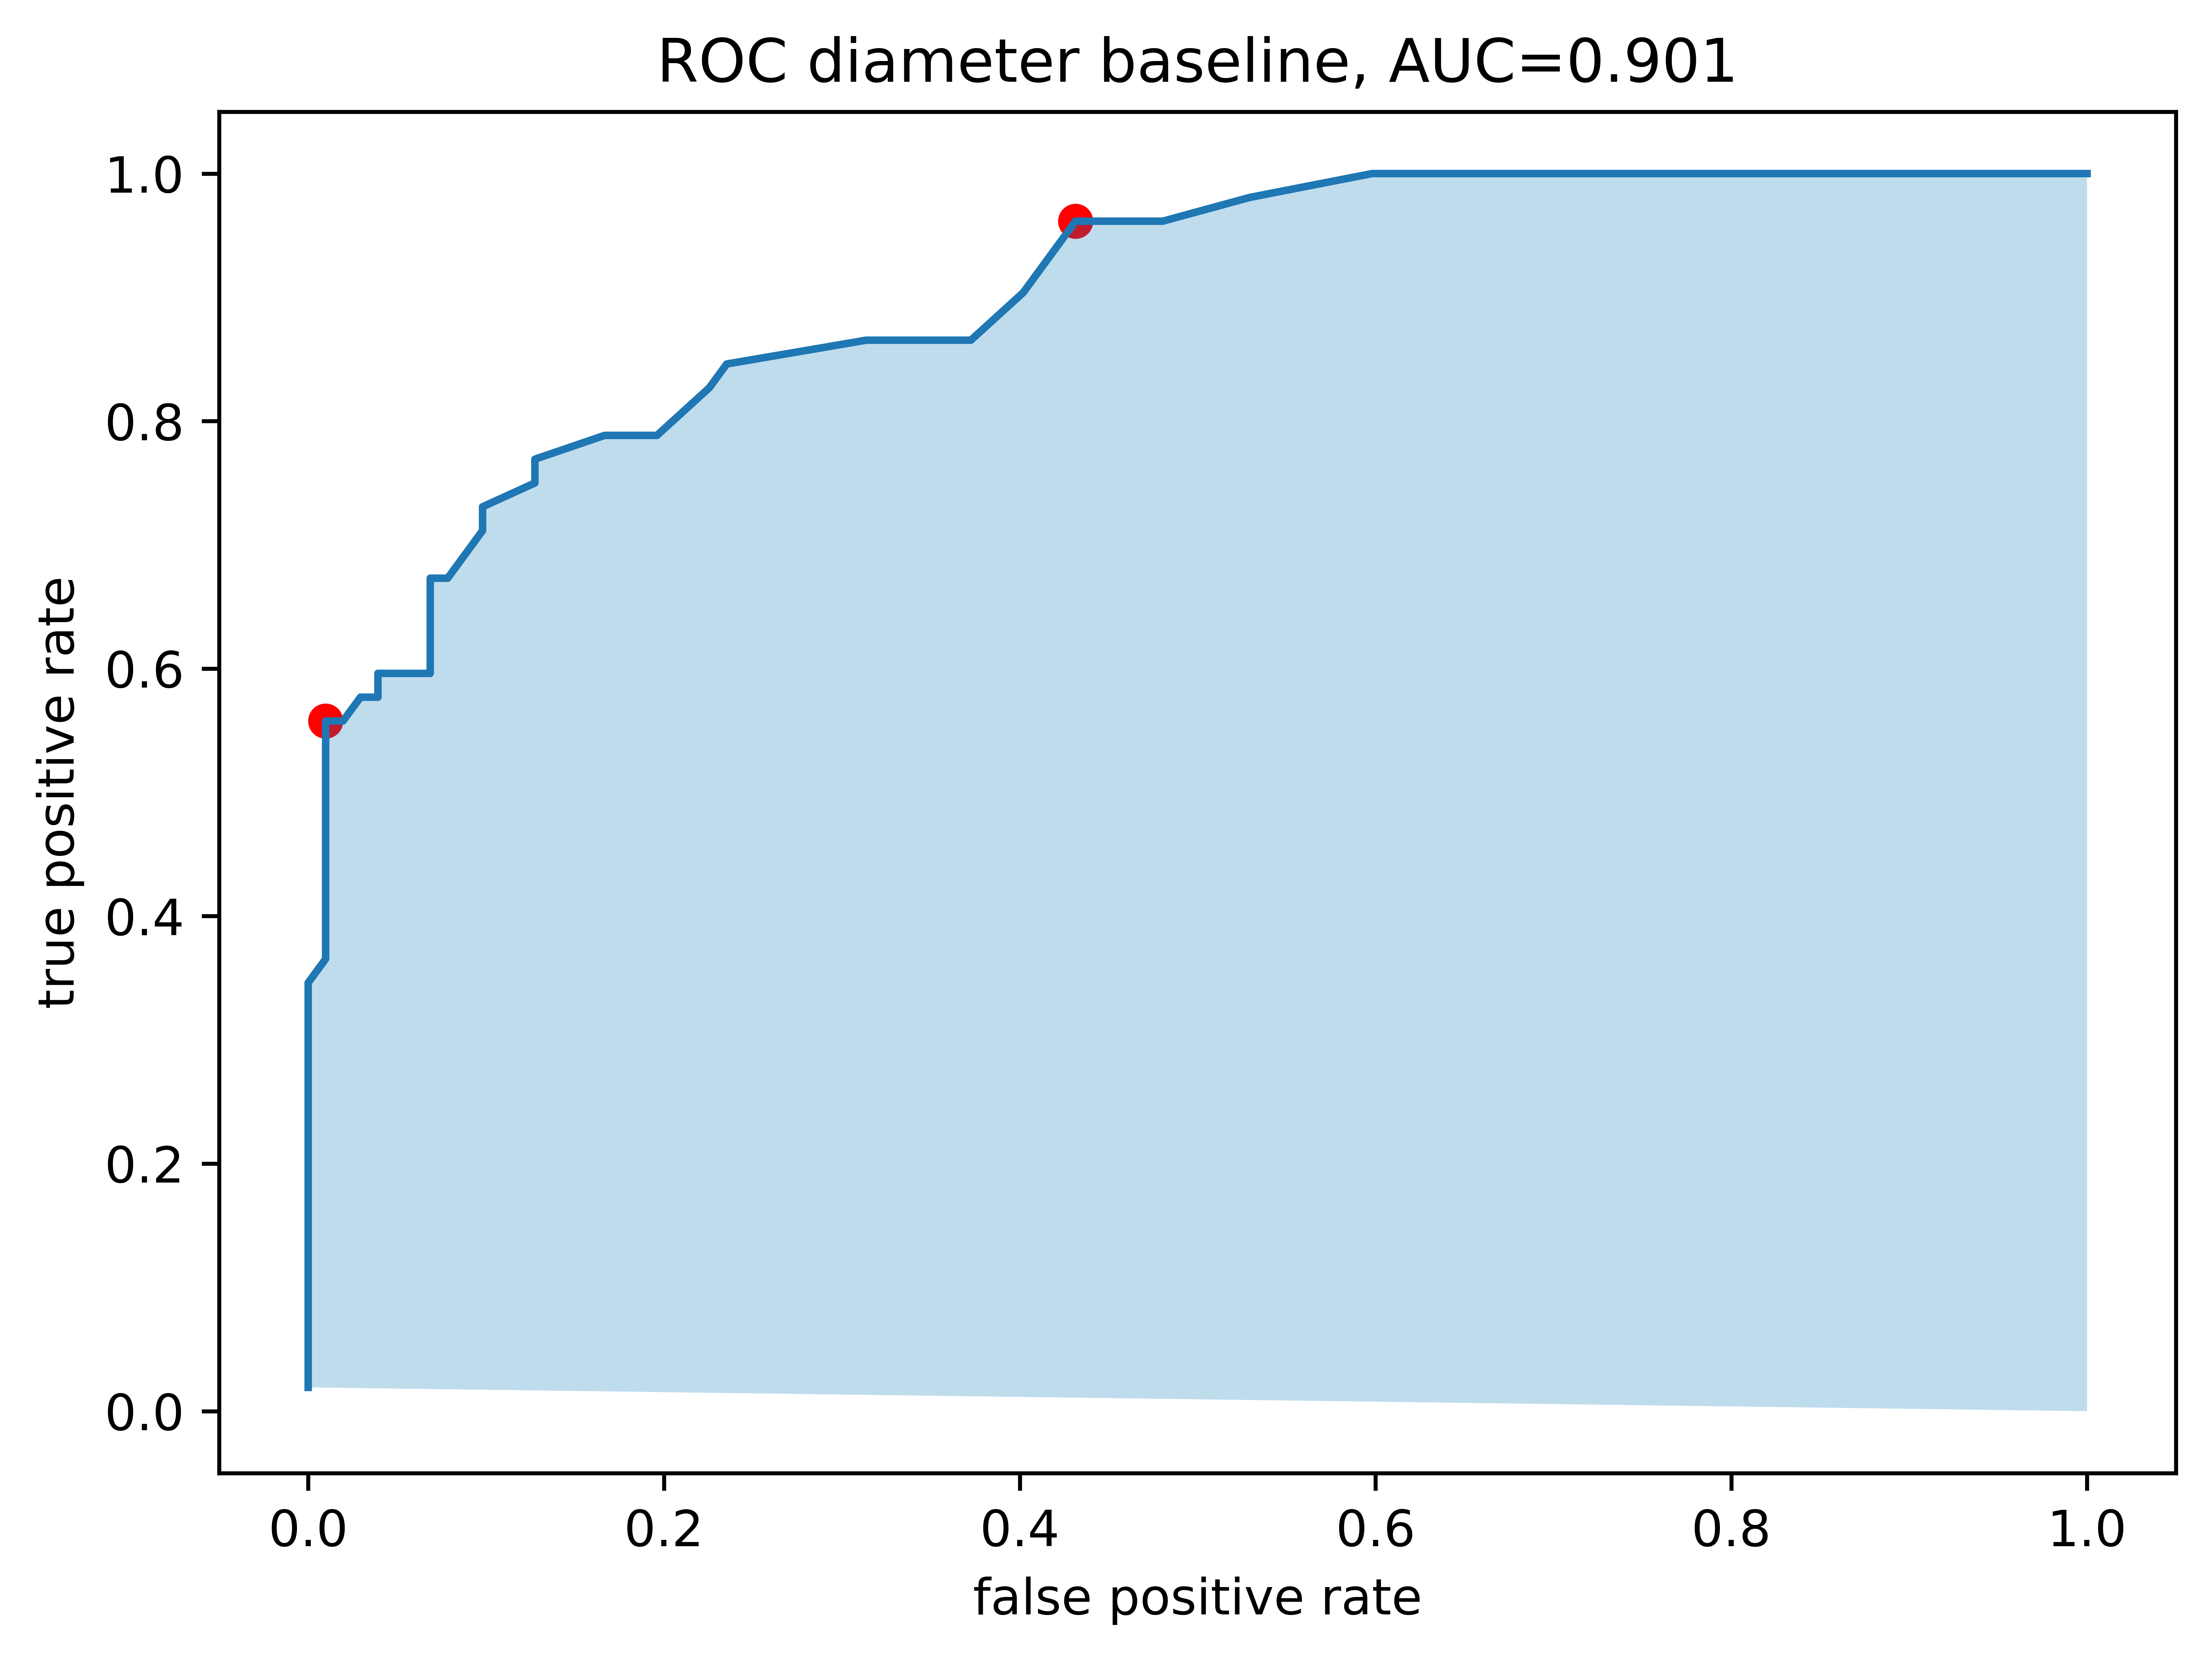

In [20]:
plt.figure(figsize=(7,5), dpi=1200)
for i in[62, 88]:
    plt.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x:{round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_dim:.3f}')
plt.title(f'ROC diameter baseline, AUC={auc_dim:.3f}')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.savefig('roc_diameter_baseline.png')

In [ ]:
model = model1.LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('data/part2/models/cls_2020-02-08_01.19.40_finetune-head.best.state')
model.load_state_dict(sd['model_state'])
model.to(device)
model.eval();